In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)


In [40]:
df= pd.read_csv('bike_data_cleaned.csv')

In [42]:
df.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,model_name_clean,kms_driven_clean,owner_clean,location_clean,mileage_clean,power_clean,kms_driven_num,mileage_num,power_num,price_num,price_range,kms_range,mileage_bin,brand,power_bin
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500,bajaj avenger cruise 220 2017,17000 km,first owner,hyderabad,35 kmpl,19 bhp,17000.0,35.0,19.0,63500,30K-70K,10k-20k,30-40,bajaj,10-20
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000,royal enfield classic 350cc 2016,50000 km,first owner,hyderabad,35 kmpl,19.80 bhp,50000.0,35.0,19.8,115000,70K-1.5L,40k-60k,30-40,royal,10-20
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000,hyosung gt250r 2012,14795 km,first owner,hyderabad,30 kmpl,28 bhp,14795.0,30.0,28.0,300000,1.5L-3L,10k-20k,20-30,hyosung,20-30
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000,bajaj dominar 400 abs 2017,mileage 28 kms,first owner,pondicherry,28 kms,34.50 bhp,28.0,28.0,34.5,100000,70K-1.5L,0-10k,20-30,bajaj,30-40
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500,jawa perak 330cc 2020,2000 km,first owner,bangalore,NaN,30 bhp,2000.0,40.0,30.0,197500,1.5L-3L,0-10k,30-40,jawa,20-30


In [43]:
df.shape

(7826, 23)

In [4]:
df.info

<bound method DataFrame.info of                             model_name  model_year       kms_driven  \
0        Bajaj Avenger Cruise 220 2017        2017         17000 Km   
1     Royal Enfield Classic 350cc 2016        2016         50000 Km   
2                  Hyosung GT250R 2012        2012         14795 Km   
3           Bajaj Dominar 400 ABS 2017        2017   Mileage 28 Kms   
4                Jawa Perak 330cc 2020        2020          2000 Km   
...                                ...         ...              ...   
7821         Yamaha YZF-R15 150cc 2011        2011          7000 Km   
7822         Bajaj Discover 100cc 2015        2015  Mileage 80 Kmpl   
7823           Bajaj Pulsar 180cc 2016        2016          6407 Km   
7824              Bajaj V15 150cc 2016        2016          7524 Km   
7825           Bajaj Pulsar 220cc 2016        2016         15000 Km   

            owner     location       mileage      power   price  \
0     first owner    hyderabad  \n\n 35 kmpl    

In [5]:
df.isnull().sum()


model_name            0
model_year            0
kms_driven            0
owner                 0
location              0
mileage              11
power                31
price                 0
model_name_clean      0
kms_driven_clean      0
owner_clean           0
location_clean        0
mileage_clean       736
power_clean          31
kms_driven_num        0
mileage_num           0
power_num             0
price_num             0
price_range           0
kms_range             0
mileage_bin           0
brand                 0
power_bin             0
dtype: int64

In [6]:
def to_numeric_safe(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()
    s = s.replace(',', '')
    s = s.replace('\n',' ').replace('\r',' ')
    s = re.sub(r'[^0-9\.\\-kkmA-Za-z]', ' ', s)
    if s == '':
        return np.nan
    return s

In [7]:
cols_to_clean = ['model_name', 'kms_driven', 'owner', 'location', 'mileage', 'power']

for col in cols_to_clean:
    df[col + '_clean'] = df[col].apply(to_numeric_safe)


In [8]:
df[['kms_driven', 'kms_driven_clean', 'mileage', 'mileage_clean']].head(5)


,kms_driven,kms_driven_clean,mileage,mileage_clean
0,17000 Km,17000 km,\n\n 35 kmpl,35 kmpl
1,50000 Km,50000 km,\n\n 35 kmpl,35 kmpl
2,14795 Km,14795 km,\n\n 30 kmpl,30 kmpl
3,Mileage 28 Kms,mileage 28 kms,\n\n 28 Kms,28 kms
4,2000 Km,2000 km,\n\n,NaN


In [9]:

def parse_kms(x):
    if pd.isna(x): return np.nan
    s = str(x).lower().replace(',', '').strip()
    s = s.replace('mileage','').replace('kms','').replace('km','').strip()
    
    # Check if value contains 'k' for thousands
    if 'k' in s:
        m = re.search(r'([0-9]+(?:\.[0-9]+)?)', s)
        return float(m.group(1)) * 1000 if m else np.nan
    
    # Otherwise take number as is
    m2 = re.search(r'([0-9]+(?:\.[0-9]+)?)', s)
    return float(m2.group(1)) if m2 else np.nan

# Mileage
def parse_mileage(x):
    if pd.isna(x): return np.nan
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)', str(x))
    return float(m.group(1)) if m else np.nan

# Power (BHP)
def parse_power(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    s = re.split(r'@|rpm', s)[0]  # remove rpm info
    m = re.search(r'([0-9]+(?:\.[0-9]+)?)', s)
    return float(m.group(1)) if m else np.nan




In [10]:
# Clean text first
df['kms_driven_clean'] = df['kms_driven'].apply(to_numeric_safe)
df['mileage_clean']   = df['mileage'].apply(to_numeric_safe)
df['power_clean']     = df['power'].apply(to_numeric_safe)

df['kms_driven_num'] = df['kms_driven_clean'].apply(parse_kms)
df['mileage_num']   = df['mileage_clean'].apply(parse_mileage)
df['power_num']     = df['power_clean'].apply(parse_power)
df['price_num']     = pd.to_numeric(df['price'], errors='coerce')


In [11]:
df[['kms_driven','kms_driven_num','mileage','mileage_num','power','power_num','price','price_num']].head()


,kms_driven,kms_driven_num,mileage,mileage_num,power,power_num,price,price_num
0,17000 Km,17000.0,\n\n 35 kmpl,35.0,19 bhp,19.0,63500,63500
1,50000 Km,50000.0,\n\n 35 kmpl,35.0,19.80 bhp,19.8,115000,115000
2,14795 Km,14795.0,\n\n 30 kmpl,30.0,28 bhp,28.0,300000,300000
3,Mileage 28 Kms,28.0,\n\n 28 Kms,28.0,34.50 bhp,34.5,100000,100000
4,2000 Km,2000.0,\n\n,NaN,30 bhp,30.0,197500,197500


In [12]:
df.isnull().sum()

model_name            0
model_year            0
kms_driven            0
owner                 0
location              0
mileage              11
power                31
price                 0
model_name_clean      0
kms_driven_clean      0
owner_clean           0
location_clean        0
mileage_clean       736
power_clean          31
kms_driven_num        3
mileage_num         772
power_num            31
price_num             0
price_range           0
kms_range             0
mileage_bin           0
brand                 0
power_bin             0
dtype: int64

In [13]:
df['kms_driven_num'].fillna(df['kms_driven_num'].median(), inplace=True)
df['mileage_num'].fillna(df['mileage_num'].median(), inplace=True)
df['power_num'].fillna(df['power_num'].median(), inplace=True)

df[['kms_driven_num','mileage_num','power_num']].isnull().sum()


kms_driven_num    0
mileage_num       0
power_num         0
dtype: int64

In [14]:
df['location'].fillna(df['location'].mode()[0], inplace=True)
df['location_clean'].fillna(df['location_clean'].mode()[0], inplace=True)

df.isnull().sum()


model_name            0
model_year            0
kms_driven            0
owner                 0
location              0
mileage              11
power                31
price                 0
model_name_clean      0
kms_driven_clean      0
owner_clean           0
location_clean        0
mileage_clean       736
power_clean          31
kms_driven_num        0
mileage_num           0
power_num             0
price_num             0
price_range           0
kms_range             0
mileage_bin           0
brand                 0
power_bin             0
dtype: int64

In [15]:
df.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,model_name_clean,kms_driven_clean,owner_clean,location_clean,mileage_clean,power_clean,kms_driven_num,mileage_num,power_num,price_num,price_range,kms_range,mileage_bin,brand,power_bin
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500,bajaj avenger cruise 220 2017,17000 km,first owner,hyderabad,35 kmpl,19 bhp,17000.0,35.0,19.0,63500,30K-70K,10k-20k,30-40,bajaj,10-20
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000,royal enfield classic 350cc 2016,50000 km,first owner,hyderabad,35 kmpl,19.80 bhp,50000.0,35.0,19.8,115000,70K-1.5L,40k-60k,30-40,royal,10-20
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000,hyosung gt250r 2012,14795 km,first owner,hyderabad,30 kmpl,28 bhp,14795.0,30.0,28.0,300000,1.5L-3L,10k-20k,20-30,hyosung,20-30
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000,bajaj dominar 400 abs 2017,mileage 28 kms,first owner,pondicherry,28 kms,34.50 bhp,28.0,28.0,34.5,100000,70K-1.5L,0-10k,20-30,bajaj,30-40
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500,jawa perak 330cc 2020,2000 km,first owner,bangalore,NaN,30 bhp,2000.0,40.0,30.0,197500,1.5L-3L,0-10k,30-40,jawa,20-30


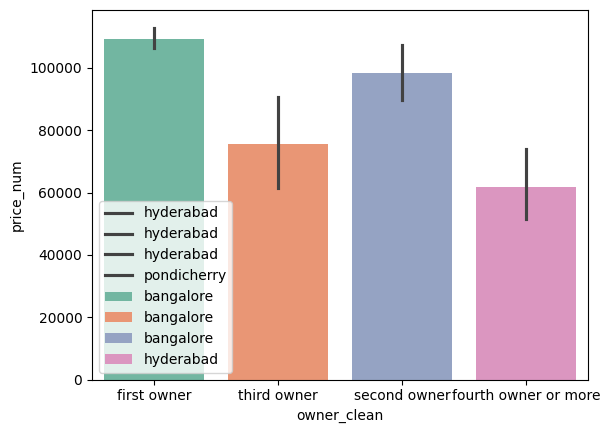

In [16]:
sns.barplot(y=df['price_num'], x=df['owner_clean'],palette='Set2')
plt.legend(df['location_clean'])
plt.show()

In [17]:
df.describe()

,model_year,price,kms_driven_num,mileage_num,power_num,price_num
count,7826.000000,7.826000e+03,7826.000000,7826.000000,7826.000000,7.826000e+03
mean,2015.393560,1.072144e+05,17223.561705,44.291036,20.791781,1.072144e+05
std,3.975738,1.390380e+05,26759.669739,16.164013,15.002115,1.390380e+05
min,1950.000000,2.000000e+03,0.000000,5.000000,6.100000,2.000000e+03
25%,2014.000000,4.250000e+04,104.000000,35.000000,14.000000,4.250000e+04
50%,2016.000000,7.500000e+04,11000.000000,40.000000,19.000000,7.500000e+04
75%,2018.000000,1.250000e+05,24856.000000,55.000000,24.160000,1.250000e+05
max,2021.000000,3.000000e+06,1000000.000000,104.000000,197.300000,3.000000e+06


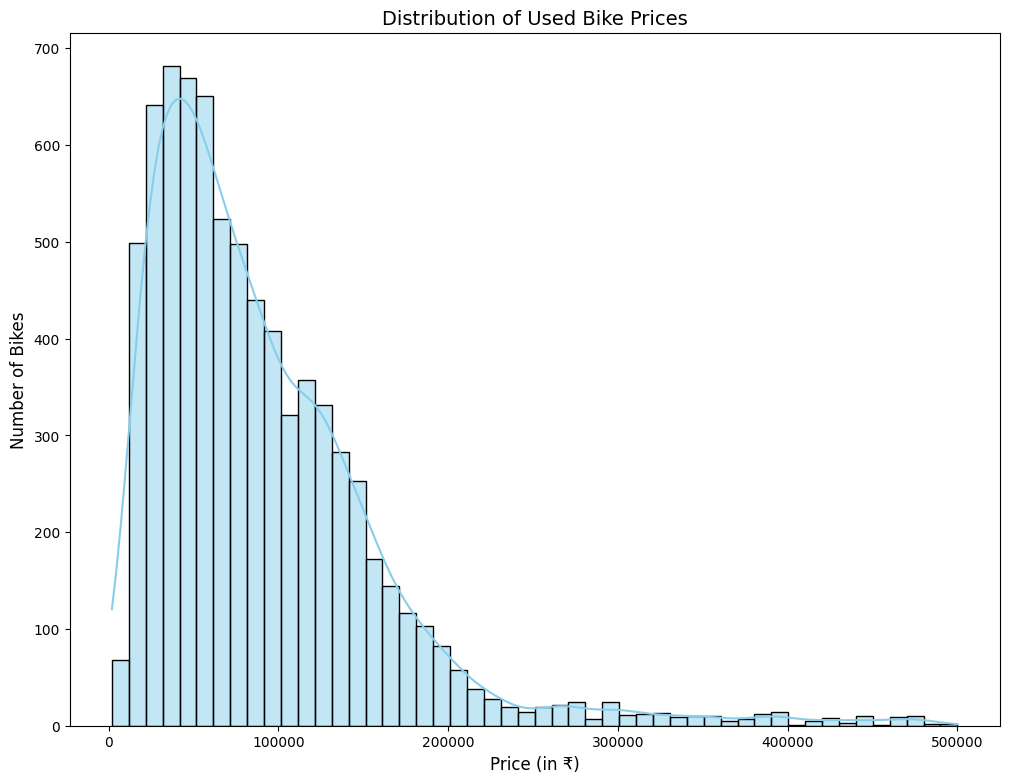

In [18]:
df = df[df['price_num'] > 0]
plt.figure(figsize=(12,9))
sns.histplot(df[df['price_num'] < 500000]['price_num'], bins=50, color='skyblue', kde=True)
plt.title("Distribution of Used Bike Prices", fontsize=14)
plt.xlabel("Price (in ₹)", fontsize=12)
plt.ylabel("Number of Bikes", fontsize=12)
plt.show()

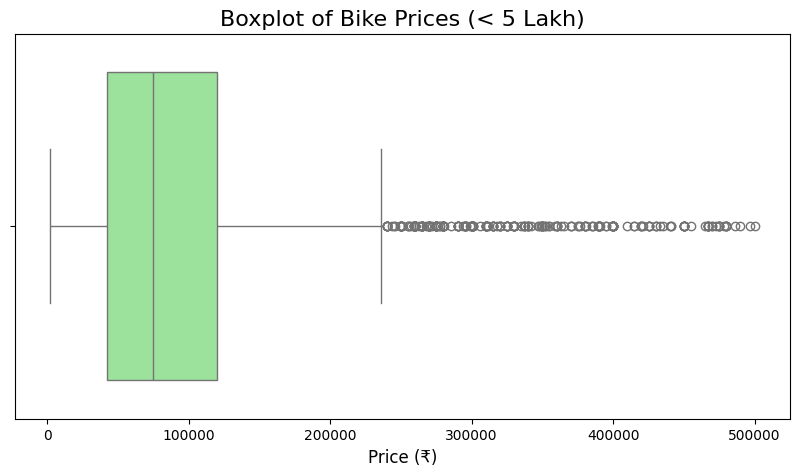

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df[df['price_num']<500000]['price_num'], color='lightgreen')
plt.title("Boxplot of Bike Prices (< 5 Lakh)", fontsize=16)
plt.xlabel("Price (₹)", fontsize=12)
plt.show()


7826


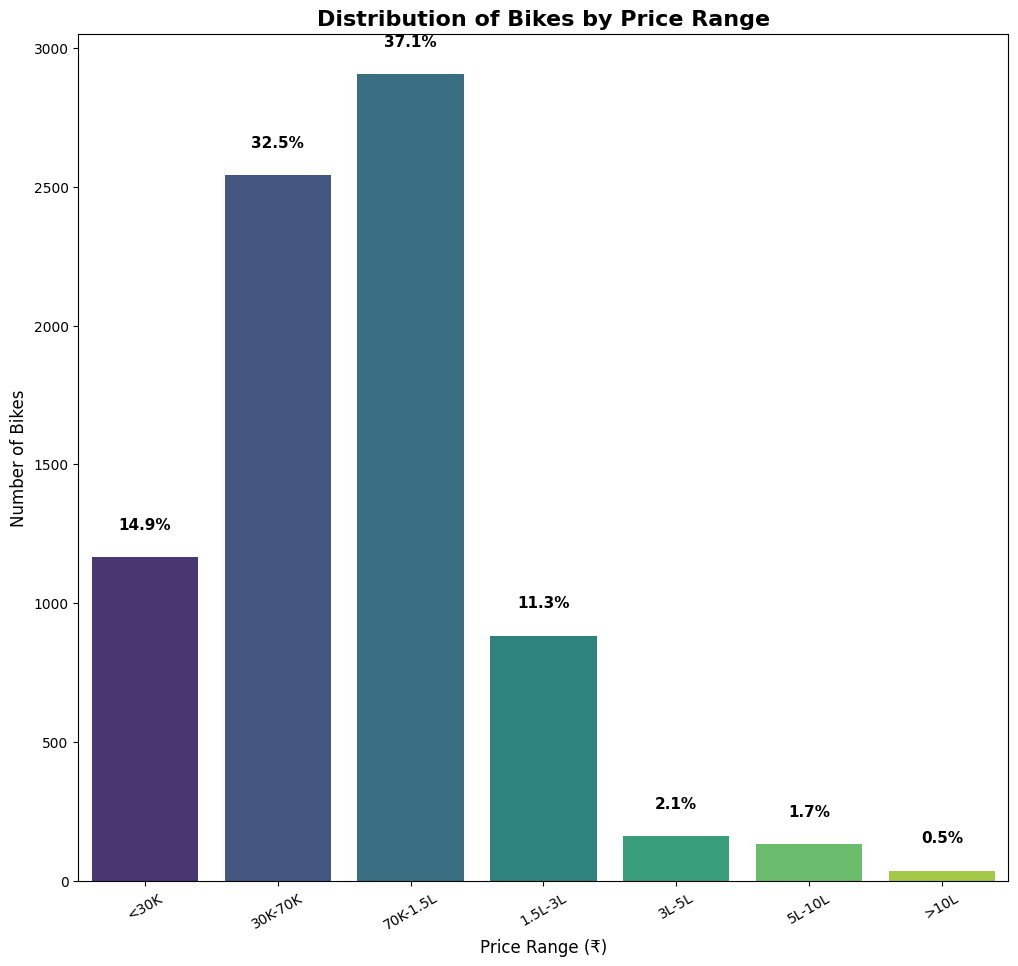

In [20]:
# Creating bins (price ranges)
bins = [0, 30000, 70000, 150000, 300000, 500000, 1000000, 3000000]
labels = ['<30K', '30K-70K', '70K-1.5L', '1.5L-3L', '3L-5L', '5L-10L', '>10L']

df['price_range'] = pd.cut(df['price_num'], bins=bins, labels=labels, include_lowest=True)

price_dist = df['price_range'].value_counts().sort_index()

price_percent = (price_dist / price_dist.sum()) * 100
print(price_dist.sum())
plt.figure(figsize=(12,11))
ax = sns.barplot(x=price_dist.index, y=price_dist.values, palette='viridis')

for i, val in enumerate(price_percent.values):
    ax.text(i, price_dist.values[i] + 100, f"{val:.1f}%", ha='center', fontsize=11, color='Black', weight='bold')

plt.title("Distribution of Bikes by Price Range", fontsize=16, weight='bold')
plt.xlabel("Price Range (₹)", fontsize=12)
plt.ylabel("Number of Bikes", fontsize=12)
plt.xticks(rotation=30)
plt.show()


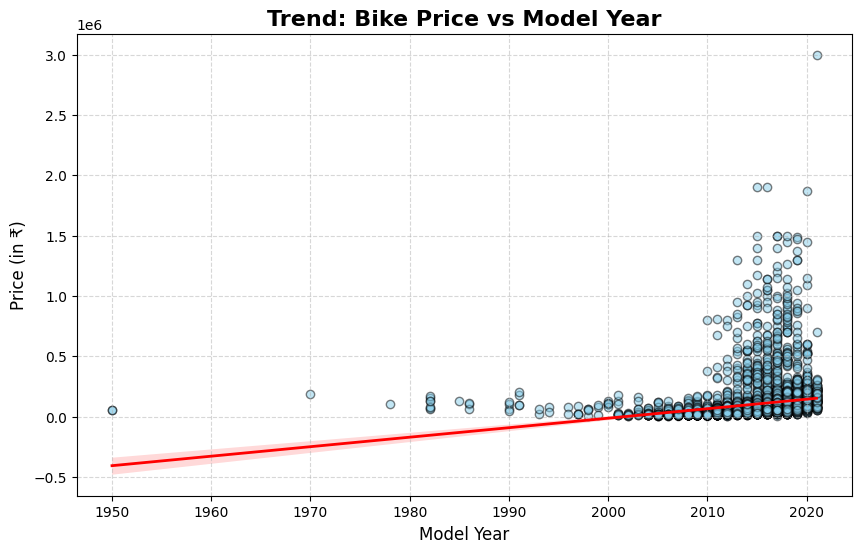

In [21]:

plt.figure(figsize=(10,6))
sns.regplot(x='model_year', y='price_num', data=df,
            scatter_kws={'alpha':0.5, 'color':'skyblue', 'edgecolor':'black'},
            line_kws={'color':'red', 'lw':2})

plt.title("Trend: Bike Price vs Model Year", fontsize=16, weight='bold')
plt.xlabel("Model Year", fontsize=12)
plt.ylabel("Price (in ₹)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [22]:
bins = [0, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 1000000]
labels = ['0-10k', '10k-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-200k', '200k+']

df['kms_range'] = pd.cut(df['kms_driven_num'], bins=bins, labels=labels, include_lowest=True)

avg_price_by_km = df.groupby('kms_range')['price_num'].mean().reset_index()
print(avg_price_by_km)


   kms_range      price_num
0      0-10k  123247.130204
1    10k-20k  120090.723652
2    20k-40k   82351.307740
3    40k-60k   59651.900971
4    60k-80k   51215.993333
5   80k-100k   47273.026087
6  100k-200k   40593.266667
7      200k+   66212.153846


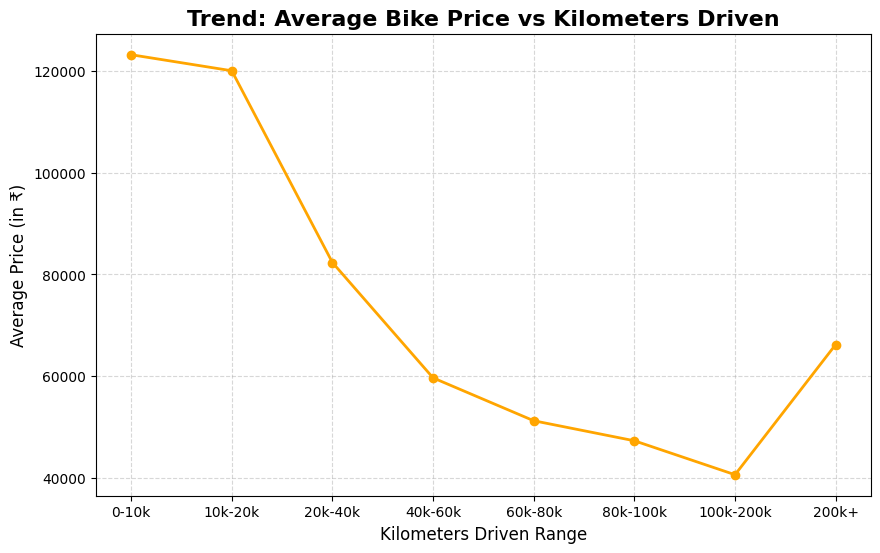

In [23]:
plt.figure(figsize=(10,6))
plt.plot(avg_price_by_km['kms_range'], avg_price_by_km['price_num'], marker='o', color='orange', linewidth=2)

plt.title("Trend: Average Bike Price vs Kilometers Driven", fontsize=16, weight='bold')
plt.xlabel("Kilometers Driven Range", fontsize=12)
plt.ylabel("Average Price (in ₹)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


0        0-10k
1      10k-20k
2      20k-40k
3      40k-60k
4      60k-80k
5     80k-100k
6    100k-200k
7        200k+
Name: kms_range, dtype: category
Categories (8, object): ['0-10k' < '10k-20k' < '20k-40k' < '40k-60k' < '60k-80k' < '80k-100k' < '100k-200k' < '200k+']


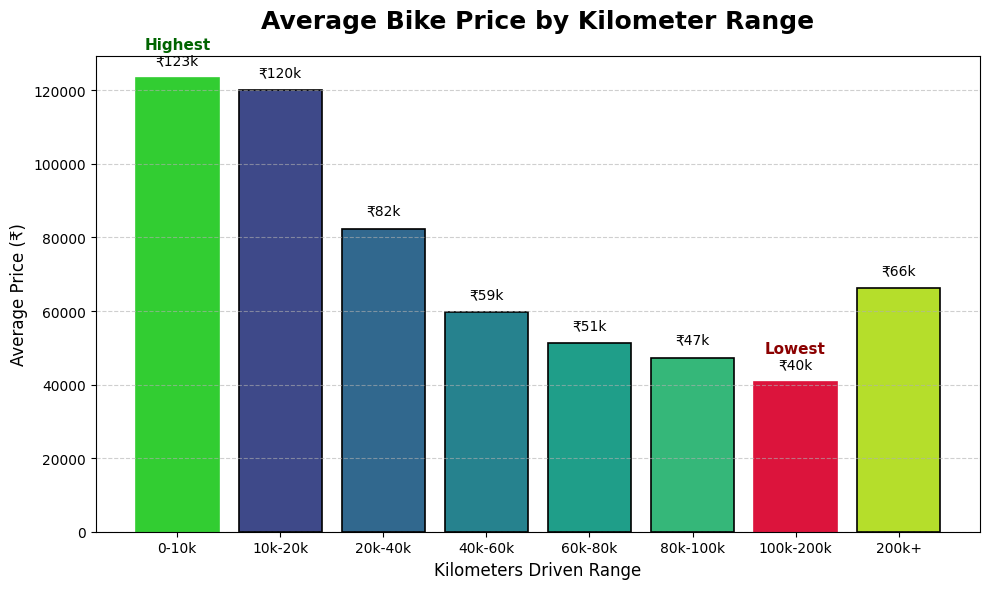

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

bins = [0, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 1000000]
labels = ['0-10k', '10k-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-200k', '200k+']
df['kms_range'] = pd.cut(df['kms_driven_num'], bins=bins, labels=labels, include_lowest=True)


avg_price_by_km = df.groupby('kms_range')['price_num'].mean().reset_index()

max_price = avg_price_by_km['price_num'].max()
min_price = avg_price_by_km['price_num'].min()
colors = sns.color_palette("viridis", len(avg_price_by_km))

plt.figure(figsize=(10,6))
bars = plt.bar(avg_price_by_km['kms_range'], avg_price_by_km['price_num'], color=colors, edgecolor='black', linewidth=1.2)
print(avg_price_by_km['kms_range'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3000, f"₹{int(yval/1000)}k", 
             ha='center', va='bottom', fontsize=10, color='black', fontweight='medium')

for bar in bars:
    if bar.get_height() == max_price:
        bar.set_color('limegreen')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8000, 'Highest', 
                 ha='center', color='darkgreen', fontsize=11, fontweight='bold')
    elif bar.get_height() == min_price:
        bar.set_color('crimson')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8000, 'Lowest', 
                 ha='center', color='darkred', fontsize=11, fontweight='bold')

plt.title("Average Bike Price by Kilometer Range", fontsize=18, weight='bold', pad=20)
plt.xlabel("Kilometers Driven Range", fontsize=12)
plt.ylabel("Average Price (₹)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


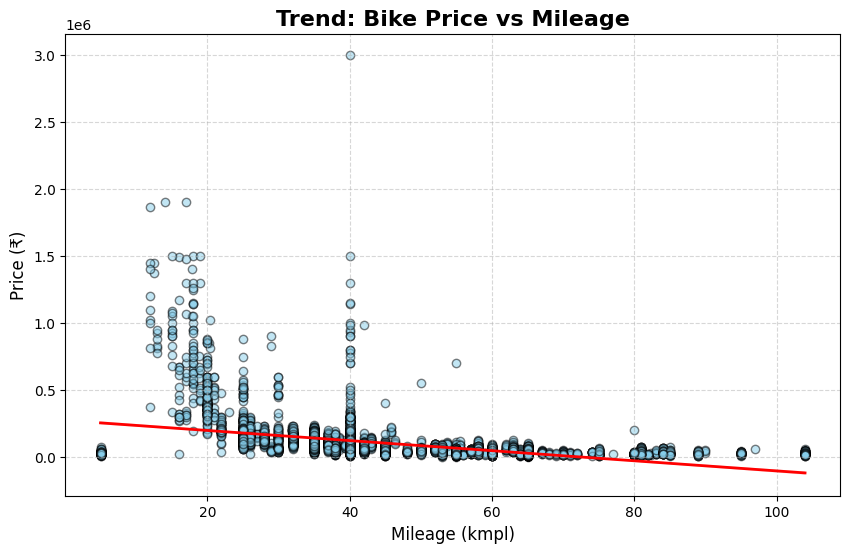

In [25]:
plt.figure(figsize=(10,6))
sns.regplot(
    x='mileage_num', 
    y='price_num', 
    data=df, 
    scatter_kws={'alpha':0.5, 'color':'skyblue', 'edgecolor':'black'}, 
    line_kws={'color':'red', 'lw':2}
)
plt.title("Trend: Bike Price vs Mileage", fontsize=16, weight='bold')
plt.xlabel("Mileage (kmpl)", fontsize=12)
plt.ylabel("Price (₹)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


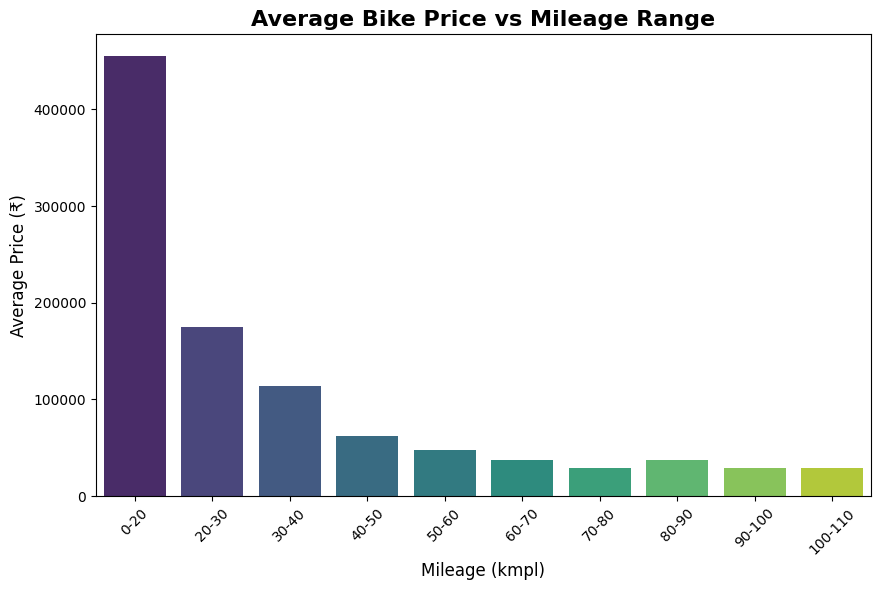

In [26]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110']
df['mileage_bin'] = pd.cut(df['mileage_num'], bins=bins, labels=labels)
mileage_price = df.groupby('mileage_bin')['price_num'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='mileage_bin', y='price_num', data=mileage_price, palette='viridis')
plt.title("Average Bike Price vs Mileage Range", fontsize=16, weight='bold')
plt.xlabel("Mileage (kmpl)", fontsize=12)
plt.ylabel("Average Price (₹)", fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [27]:
df.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,model_name_clean,kms_driven_clean,owner_clean,location_clean,mileage_clean,power_clean,kms_driven_num,mileage_num,power_num,price_num,price_range,kms_range,mileage_bin,brand,power_bin
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500,bajaj avenger cruise 220 2017,17000 km,first owner,hyderabad,35 kmpl,19 bhp,17000.0,35.0,19.0,63500,30K-70K,10k-20k,30-40,bajaj,10-20
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000,royal enfield classic 350cc 2016,50000 km,first owner,hyderabad,35 kmpl,19.80 bhp,50000.0,35.0,19.8,115000,70K-1.5L,40k-60k,30-40,royal,10-20
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000,hyosung gt250r 2012,14795 km,first owner,hyderabad,30 kmpl,28 bhp,14795.0,30.0,28.0,300000,1.5L-3L,10k-20k,20-30,hyosung,20-30
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000,bajaj dominar 400 abs 2017,mileage 28 kms,first owner,pondicherry,28 kms,34.50 bhp,28.0,28.0,34.5,100000,70K-1.5L,0-10k,20-30,bajaj,30-40
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500,jawa perak 330cc 2020,2000 km,first owner,bangalore,NaN,30 bhp,2000.0,40.0,30.0,197500,1.5L-3L,0-10k,30-40,jawa,20-30


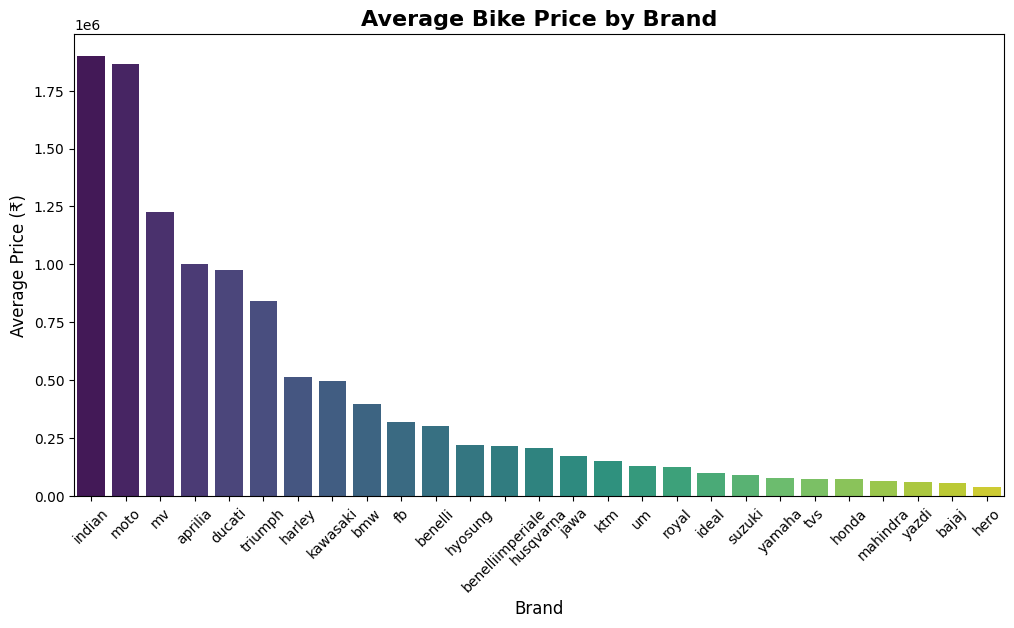

In [28]:
brand_avg_price = df.groupby('brand')['price_num'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values, palette='viridis')

plt.title("Average Bike Price by Brand", fontsize=16, weight='bold')
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Average Price (₹)", fontsize=12)
plt.xticks(rotation=45)
plt.show()

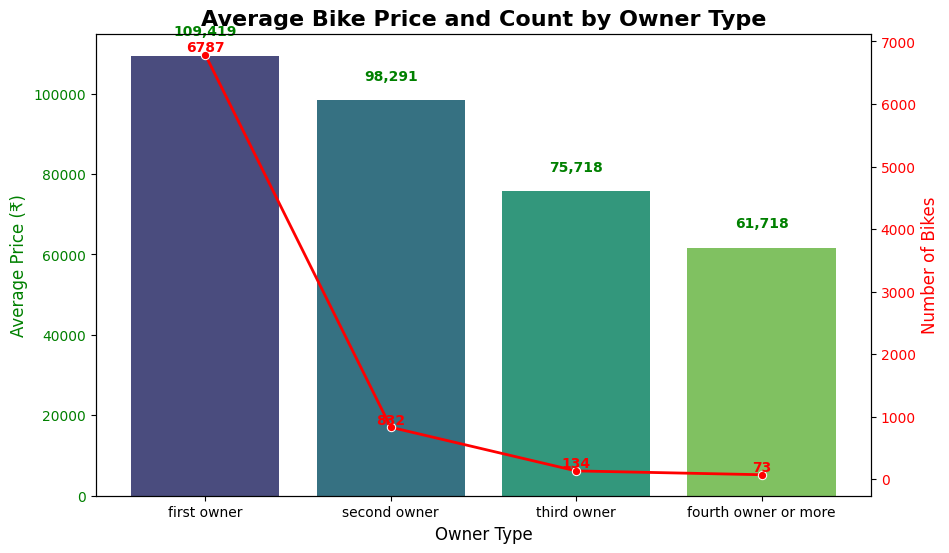

In [29]:
owner_order = ['first owner', 'second owner', 'third owner', 'fourth owner or more']

owner_data = df.groupby('owner_clean').agg(
    avg_price=('price_num', 'mean'),
    count=('price_num', 'count')
).reindex(owner_order).reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

bars = sns.barplot(x='owner_clean', y='avg_price', data=owner_data, palette='viridis', ax=ax1)
ax1.set_xlabel("Owner Type", fontsize=12)
ax1.set_ylabel("Average Price (₹)", fontsize=12, color='green')
ax1.tick_params(axis='y', labelcolor='green')

for i, row in owner_data.iterrows():
    if not pd.isna(row['avg_price']):
        ax1.text(i, row['avg_price'] + 5000, f"{int(row['avg_price']):,}", ha='center', color='green', weight='bold')

ax2 = ax1.twinx()
line = sns.lineplot(x='owner_clean', y='count', data=owner_data, color='red', marker='o', linewidth=2, ax=ax2)
ax2.set_ylabel("Number of Bikes", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

for i, row in owner_data.iterrows():
    if not pd.isna(row['count']):
        ax2.text(i, row['count'] + 50, f"{row['count']}", color='red', weight='bold', ha='center')

plt.title("Average Bike Price and Count by Owner Type", fontsize=16, weight='bold')
plt.show()


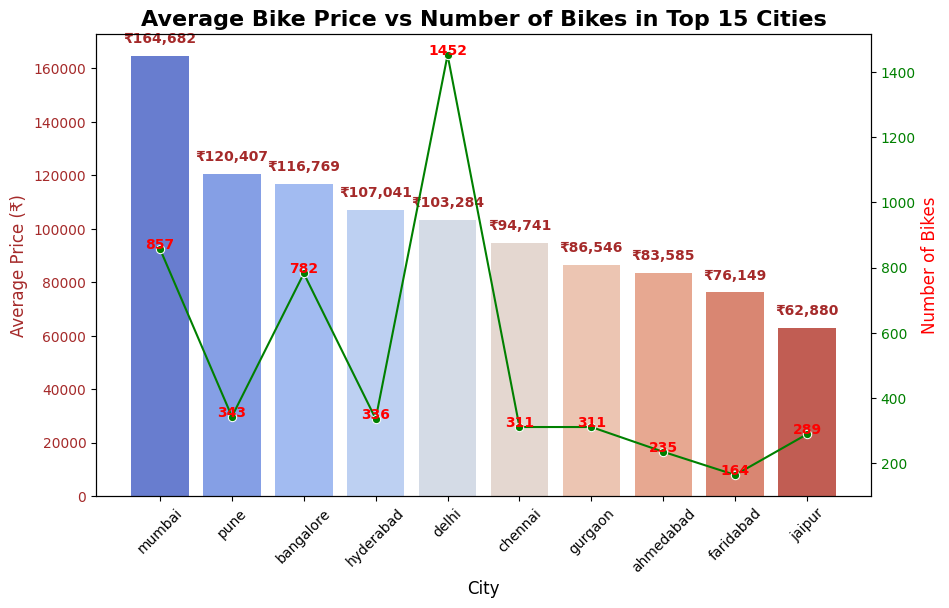

In [45]:

top_cities = df['location_clean'].value_counts().head(10).index
df_top_cities = df[df['location_clean'].isin(top_cities)]

avg_price = df_top_cities.groupby('location_clean')['price_num'].mean().sort_values(ascending=False)

bike_count = df_top_cities['location_clean'].value_counts().loc[avg_price.index]

fig, ax1 = plt.subplots(figsize=(10,6))

bars = sns.barplot(x=avg_price.index, y=avg_price.values, palette='coolwarm', ax=ax1)
ax1.set_xlabel("City", fontsize=12)
ax1.set_ylabel("Average Price (₹)", fontsize=12, color='brown')
ax1.tick_params(axis='y', labelcolor='brown')
plt.xticks(rotation=45)

for i, val in enumerate(avg_price.values):
    ax1.text(i, val + 5000, f"₹{int(val):,}", ha='center', color='brown', weight='bold')

ax2 = ax1.twinx()
line = sns.lineplot(x=avg_price.index, y=bike_count.values, marker='o', sort=False, color='green', ax=ax2)
ax2.set_ylabel("Number of Bikes", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='green')

for i, val in enumerate(bike_count.values):
    ax2.text(i, val + 1, f"{val}", ha='center', color='red', weight='bold')

plt.title("Average Bike Price vs Number of Bikes in Top 15 Cities", fontsize=16, weight='bold')
plt.show()


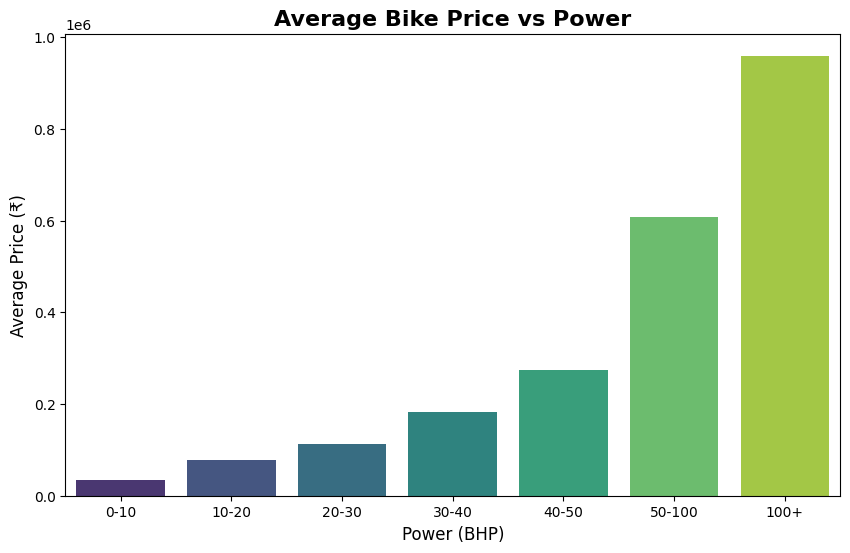

In [31]:
bins = [0, 10, 20, 30, 40, 50, 100, 200]  # BHP ranges
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+']

df['power_bin'] = pd.cut(df['power_num'], bins=bins, labels=labels)
power_price = df.groupby('power_bin')['price_num'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='power_bin', y='price_num', data=power_price, palette='viridis')

plt.title("Average Bike Price vs Power", fontsize=16, weight='bold')
plt.xlabel("Power (BHP)", fontsize=12)
plt.ylabel("Average Price (₹)", fontsize=12)
plt.show()

                                                          Model for prediction 

In [32]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# data=df[['model_year', 'kms_driven_num', 'owner_clean', 'location_clean',
#  'mileage_num', 'power_num', 'brand', 'price_num']].copy()
# data=data.dropna()
# data_filtered = data[(data['price_num'] >= 20000) & (data['price_num'] <= 300000)]

# le_owner=LabelEncoder()
# le_brand = LabelEncoder()
# data_filtered['owner_encoded']=le_owner.fit_transform(data_filtered['owner_clean'])
# data_filtered['brand_encoded']=le_brand.fit_transform(data_filtered['brand'])

# X=data_filtered[['model_year', 'kms_driven_num', 'power_num', 'mileage_num', 'owner_encoded', 'brand_encoded']]
# y=data_filtered['price_num']
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

# model=LinearRegression()
# model.fit(X_train,y_train)

# y_pred =model.predict(X_test)

# r2=r2_score(y_test,y_pred)
# mae=mean_absolute_error(y_test,y_pred)
# rmse=mean_squared_error(y_test,y_pred)

# print("Model Performance:")
# print(f"R² Score: {r2:.2f}")
# print(f"MAE: ₹{mae:,.0f}")
# print(f"RMSE: ₹{rmse:,.0f}")

In [33]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

data = df[['model_year', 'kms_driven_num', 'owner_clean', 'location_clean',
           'mileage_num', 'power_num', 'brand', 'price_num']].copy()
data = data.dropna()

# Filter out extreme outliers
data_filtered = data[(data['price_num'] >= 20000) & (data['price_num'] <= 300000)]

# Encode categorical features
le_owner = LabelEncoder()
le_brand = LabelEncoder()
data_filtered['owner_encoded'] = le_owner.fit_transform(data_filtered['owner_clean'])
data_filtered['brand_encoded'] = le_brand.fit_transform(data_filtered['brand'])

# Features and target
X = data_filtered[['model_year', 'kms_driven_num', 'power_num', 'mileage_num', 'owner_encoded', 'brand_encoded']]
y = data_filtered['price_num']

# Log-transform the target
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  
r2 = r2_score(y_test_log, y_pred_log)  
mae = mean_absolute_error(y_test_log, y_pred_log)
rmse = mean_squared_error(y_test_log, y_pred_log) ** 0.5

mae_orig = mean_absolute_error(np.expm1(y_test_log), y_pred)
rmse_orig = mean_squared_error(np.expm1(y_test_log), y_pred) ** 0.5


print("Model Performance (log scale):")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}\n")

print("Model Performance (original scale):")
print(f"MAE: ₹{mae_orig:,.0f}")
print(f"RMSE: ₹{rmse_orig:,.0f}")


Model Performance (log scale):
R² Score: 0.75
MAE: 0.25
RMSE: 0.32

Model Performance (original scale):
MAE: ₹22,361
RMSE: ₹35,407


In [34]:

data = df[['model_year', 'kms_driven_num', 'owner_clean', 'location_clean',
           'mileage_num', 'power_num', 'brand', 'price_num']].copy()
data = data.dropna()

data_filtered = data[(data['price_num'] >= 20000) & (data['price_num'] <= 300000)]

le_owner = LabelEncoder()
le_brand = LabelEncoder()
data_filtered['owner_encoded'] = le_owner.fit_transform(data_filtered['owner_clean'])
data_filtered['brand_encoded'] = le_brand.fit_transform(data_filtered['brand'])

X = data_filtered[['model_year', 'kms_driven_num', 'power_num', 'mileage_num', 
                   'owner_encoded', 'brand_encoded']]
y = data_filtered['price_num']

y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train_log)

y_pred_log = rf_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  

r2_log = r2_score(y_test_log, y_pred_log)
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = mean_squared_error(y_test_log, y_pred_log) ** 0.5

mae_orig = mean_absolute_error(np.expm1(y_test_log), y_pred)
rmse_orig = mean_squared_error(np.expm1(y_test_log), y_pred) ** 0.5

print("Random Forest Performance (log scale):")
print(f"R² Score: {r2_log:.2f}")
print(f"MAE: {mae_log:.2f}")
print(f"RMSE: {rmse_log:.2f}\n")

print("Random Forest Performance (original scale):")
print(f"MAE: ₹{mae_orig:,.0f}")
print(f"RMSE: ₹{rmse_orig:,.0f}")




Random Forest Performance (log scale):
R² Score: 0.91
MAE: 0.14
RMSE: 0.19

Random Forest Performance (original scale):
MAE: ₹11,758
RMSE: ₹17,236


Random Forest Performance (log scale):
R² Score: 0.90
MAE: 0.17
RMSE: 0.25

Random Forest Performance (original scale):
MAE: ₹14,397
RMSE: ₹31,074


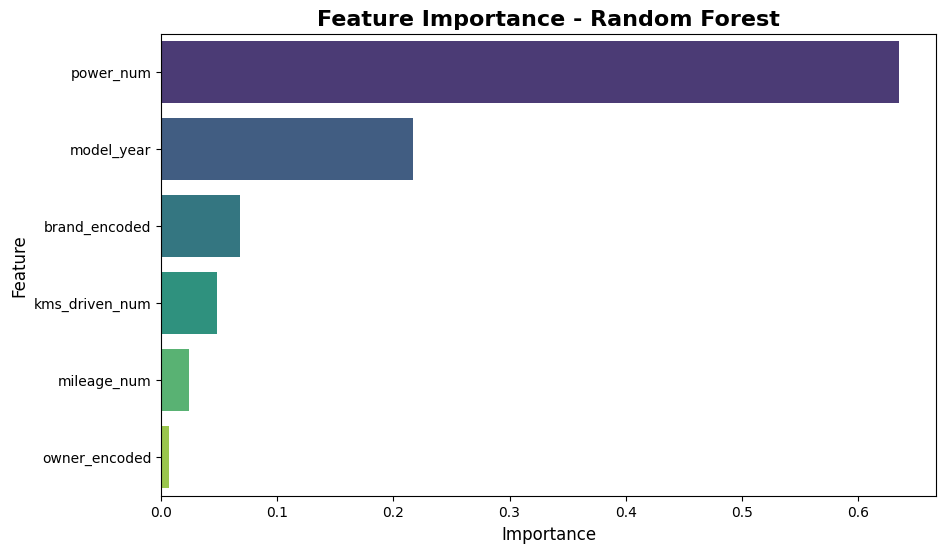

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = df[['model_year', 'kms_driven_num', 'owner_clean', 'location_clean',
           'mileage_num', 'power_num', 'brand', 'price_num']].copy()
data = data.dropna()

data_filtered = data[(data['price_num'] >= 10000) & (data['price_num'] <= 800000)]

le_owner = LabelEncoder()
le_brand = LabelEncoder()
data_filtered['owner_encoded'] = le_owner.fit_transform(data_filtered['owner_clean'])
data_filtered['brand_encoded'] = le_brand.fit_transform(data_filtered['brand'])

X = data_filtered[['model_year', 'kms_driven_num', 'power_num', 'mileage_num', 'owner_encoded', 'brand_encoded']]
y = data_filtered['price_num']

y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  

r2 = r2_score(y_test_log, y_pred_log)
mae = mean_absolute_error(y_test_log, y_pred_log)
rmse = mean_squared_error(y_test_log, y_pred_log) ** 0.5

mae_orig = mean_absolute_error(np.expm1(y_test_log), y_pred)
rmse_orig = mean_squared_error(np.expm1(y_test_log), y_pred) ** 0.5

print("Random Forest Performance (log scale):")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}\n")

print("Random Forest Performance (original scale):")
print(f"MAE: ₹{mae_orig:,.0f}")
print(f"RMSE: ₹{rmse_orig:,.0f}")

feature_importances = model.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Feature Importance - Random Forest", fontsize=16, weight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()


In [36]:
df.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,model_name_clean,kms_driven_clean,owner_clean,location_clean,mileage_clean,power_clean,kms_driven_num,mileage_num,power_num,price_num,price_range,kms_range,mileage_bin,brand,power_bin
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500,bajaj avenger cruise 220 2017,17000 km,first owner,hyderabad,35 kmpl,19 bhp,17000.0,35.0,19.0,63500,30K-70K,10k-20k,30-40,bajaj,10-20
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000,royal enfield classic 350cc 2016,50000 km,first owner,hyderabad,35 kmpl,19.80 bhp,50000.0,35.0,19.8,115000,70K-1.5L,40k-60k,30-40,royal,10-20
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000,hyosung gt250r 2012,14795 km,first owner,hyderabad,30 kmpl,28 bhp,14795.0,30.0,28.0,300000,1.5L-3L,10k-20k,20-30,hyosung,20-30
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000,bajaj dominar 400 abs 2017,mileage 28 kms,first owner,pondicherry,28 kms,34.50 bhp,28.0,28.0,34.5,100000,70K-1.5L,0-10k,20-30,bajaj,30-40
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500,jawa perak 330cc 2020,2000 km,first owner,bangalore,NaN,30 bhp,2000.0,40.0,30.0,197500,1.5L-3L,0-10k,30-40,jawa,20-30
